# Preprocessing prediction results

In [11]:
import glob
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import tqdm
import gc
from scipy.stats import pearsonr, spearmanr

def get_R(data1,data2,dim=1,func=pearsonr):
    from scipy.sparse import issparse
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2):
    from skimage.metrics import structural_similarity as ssim
    adata1=data1.X
    adata2=data2.X
    ssim_score = ssim(adata1, adata2, data_range=adata1.max() - adata2.min())
    return ssim_score

# Graph Construction Comparison



In [ ]:
# Read the method names
Methods = ["Default", "PAG_GAG", "PAG", "GAG"]

# Organize the results into a dataframe
for method in tqdm.tqdm(Methods):
    # Read the slide names
    slides = list(set(slide.split("/")[3].split("_")[3] for slide in glob.glob(f"Results/BC_visium/{method}/*h5ad")))
    
    for slide in slides:
        gc.collect()
        data1 = sc.read_h5ad(glob.glob(f"Results/BC_visium/{method}/pred_BC_visium_{slide}*.h5ad")[0])
        data2 = sc.read_h5ad(glob.glob(f"Results/BC_visium/{method}/gt_BC_visium_{slide}*.h5ad")[0])
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        PCC_BC_Visium = {
        "Gene": list(data2.var_names),
        "Pearson correlation": pcc,
        "PCC_PValue": PCC_PValue,
        "Spearmanr correlation": SPC,
        "SSIM_Score": ssim_score,
        "SPC_PValue": SPC_PValue,
        "Slide": [slide]*len(pcc),
        "Method": [method]*len(pcc),
        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
        PCC_BC_Visium.to_csv(f"Results/BC_visium/{method}/{method}_{slide}.csv")
        
    res = glob.glob(f"Results/BC_visium/{method}/{method}*.csv")
    df = [pd.read_csv(i, index_col=[0]) for i in res]
    df = pd.concat(df)
    df.to_csv(f"Results/BC_visium/{method}/Summary.csv")
    
df = pd.concat([pd.read_csv(f"Results/BC_visium/{method}/Summary.csv", index_col=[0]) for method in Methods])
df.to_csv("Results/BC_visium/GraphBuild.csv")
df 

In [13]:
df.to_csv("Results/BC_visium/GraphBuild.csv")

In [14]:
import pandas as pd

df = pd.read_csv("Results/BC_visium/GraphBuild.csv", index_col=[0])
df["Dataset"] = "BC_Visium"
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SSIM_Score,SPC_PValue,Slide,Method,Dataset
0,ABL1,-0.013440,6.665476e-01,-0.025828,0.439995,7.959457e-01,CID4535,Default,BC_Visium
1,ABL2,0.049558,5.614572e-02,0.050629,0.439995,5.236379e-02,CID4535,Default,BC_Visium
2,ABRAXAS1,-0.036214,8.769931e-01,-0.014611,0.439995,6.800781e-01,CID4535,Default,BC_Visium
3,ACTN1,0.038136,1.109103e-01,0.019862,0.439995,2.623474e-01,CID4535,Default,BC_Visium
4,ACTN4,-0.046924,9.336439e-01,-0.046998,0.439995,9.339493e-01,CID4535,Default,BC_Visium
...,...,...,...,...,...,...,...,...,...
1625,XBP1,0.248636,6.504318e-55,0.295680,0.490330,8.458306e-78,block1,GAG,BC_Visium
1626,XCR1,-0.000068,5.016591e-01,-0.010192,0.490330,7.349671e-01,block1,GAG,BC_Visium
1627,YTHDF2,0.182653,3.776320e-30,0.178436,0.490330,7.664700e-29,block1,GAG,BC_Visium
1628,ZAP70,0.080415,3.484592e-07,0.075370,0.490330,1.659762e-06,block1,GAG,BC_Visium


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


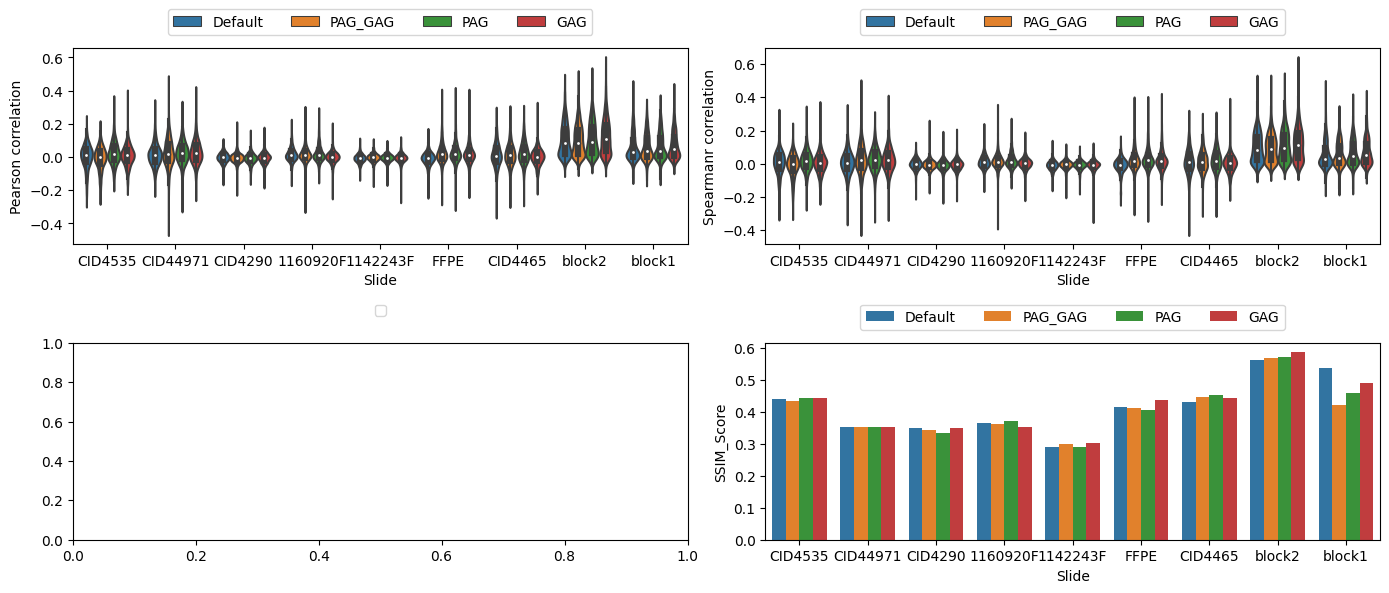

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

gc.collect()
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 6))

# Plot the first figure
sns.violinplot(x='Slide', y='Pearson correlation', hue='Method', data=df, ax=axs[0][0])
# axs[0].set_title('Pearson Correlation of Predictable Genes Across Slides')

# Plot the second figure
sns.violinplot(x='Slide', y='Spearmanr correlation', hue='Method', data=df, ax=axs[0][1])

# Plot the third figure
sns.barplot(x='Slide', y='SSIM_Score', hue='Method', data=df, ax=axs[1][1])
# axs[1].set_title('Spearmanr Correlation of Predictable Genes Across Slides')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Move the legend outside the plot area
for x in axs:
    for ax in x:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.23),
            ncol=7,
        )

# Show the plots
# plt.show()
plt.savefig("GraphBuild.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


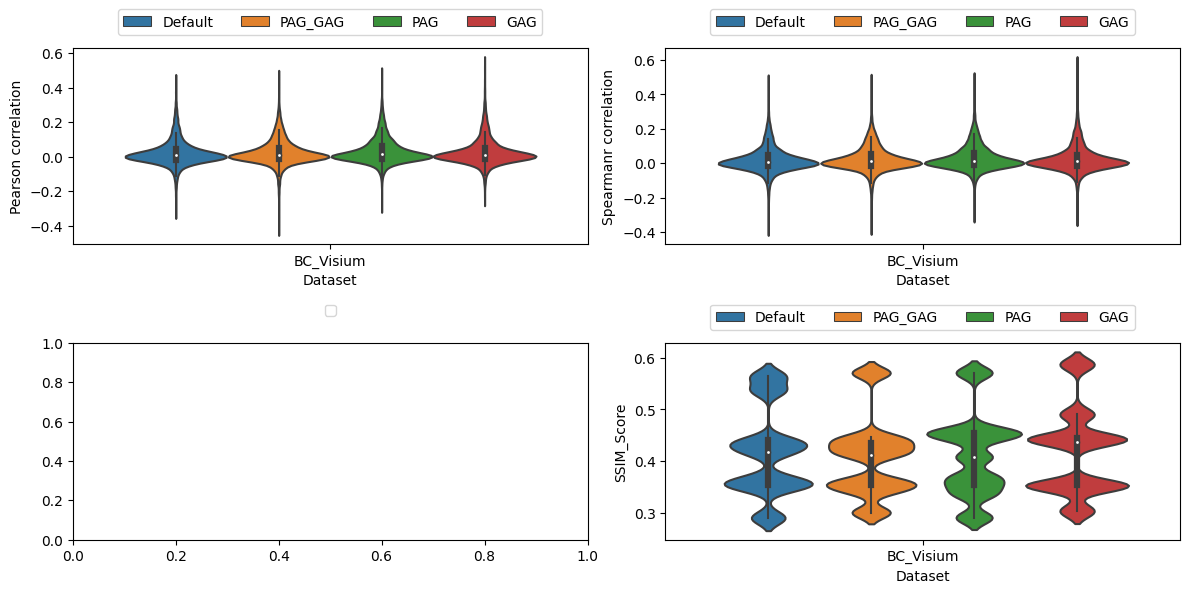

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

gc.collect()
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot the first figure
sns.violinplot(x='Dataset', y='Pearson correlation', hue='Method', data=df, ax=axs[0][0])
# axs[0].set_title('Pearson Correlation of Predictable Genes Across Slides')

# Plot the second figure
sns.violinplot(x='Dataset', y='Spearmanr correlation', hue='Method', data=df, ax=axs[0][1])
# axs[1].set_title('Spearmanr Correlation of Predictable Genes Across Slides')

# Plot the third figure
sns.violinplot(x='Dataset', y='SSIM_Score', hue='Method', data=df, ax=axs[1][1])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Move the legend outside the plot area
for x in axs:
    for ax in x:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.23),
            ncol=7,
        )
# Show the plots
plt.savefig("GraphBuild_Overview.png")
plt.show()


In [71]:
from scipy.stats import wilcoxon

# Example data
data1 = Default
data2 = PAG # PAG_GAG, GAG, PAG

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(data1, data2, alternative='two-sided')  # 'greater' for one-tailed greater-than test

# Print results
print("Wilcoxon Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference (one-tailed greater-than test).")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")


Wilcoxon Statistic: nan
P-value: nan
Fail to reject the null hypothesis: There is no significant difference.


# Top predictable genes


In [21]:
def top_predictable_genes(df_all, dataset, method, num=5):
    df = df_all[df_all["Method"]==method]
    top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)
    top5_genes = list(top5_df.index)
    # Subset the results according to top predictable gene
    num_pos = []
    for g in top5_genes:
        subset_df = df[df["Gene"]==g]
        count_positive_corr = subset_df[subset_df['Pearson correlation'] > 0].shape[0]
        # print(f'Number of positive Pearson correlation values: {count_positive_corr}')
        num_pos.append(int(count_positive_corr))
    top5_df["Number of consistent samples"] = num_pos
    top5_df["Method"] = method
    top5_df["Dataset"] = dataset
    top5_df = top5_df[[(                      'Method',       ''),
            (                     'Dataset',       ''),
            ('Number of consistent samples',       ''),
            (         'Pearson correlation',   'mean'),
            (         'Pearson correlation', 'median'),
            (         'Pearson correlation',    'max'),
            (         'Pearson correlation',    'std'),
            
            ]]

    return top5_df

In [30]:
x1 = set(top_predictable_genes(df, "BC_Visium", "Default", num=100).index)
x2 = set(top_predictable_genes(df, "BC_Visium", "PAG_GAG", num=100).index)
x3 = set(top_predictable_genes(df, "BC_Visium", "PAG", num=100).index)
x4 = set(top_predictable_genes(df, "BC_Visium", "GAG", num=100).index)
predictable_genes = list(x1.intersection(x2, x3, x4))
print(f"There are {len(predictable_genes)} genes that are predictable by all methods.")
predictable_genes

There are 14 genes that are predictable by all methods.


['ITGB1',
 'CD164',
 'ACTN4',
 'MIF',
 'S100A9',
 'HUWE1',
 'TBL1XR1',
 'TRAF2',
 'RPN2',
 'PRKCI',
 'FOXA1',
 'IGKC',
 'RAC1',
 'IDH2']

In [67]:
# df1 is the results for predictable genes (subset of df)
df1 = df[df["Gene"].isin(predictable_genes)]
df1 = df1.reset_index().drop("index",axis=1)

# df2 is summary information for comparing methods
df2 = df1[["Method", "Pearson correlation"]].groupby("Method", as_index=False).agg(['median', 'mean', 'max', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
df2

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SSIM_Score,SPC_PValue,Slide,Method,Dataset
0,ACTN4,-0.046924,9.336439e-01,-0.046998,0.439995,9.339493e-01,CID4535,Default,BC_Visium
1,CD164,0.084077,3.496150e-03,0.049043,0.439995,5.803642e-02,CID4535,Default,BC_Visium
2,FOXA1,0.109975,2.058308e-04,0.135960,0.439995,6.092678e-06,CID4535,Default,BC_Visium
3,HUWE1,0.055341,3.806698e-02,0.023190,0.439995,2.288267e-01,CID4535,Default,BC_Visium
4,IDH2,0.069416,1.301984e-02,0.062669,0.439995,2.227629e-02,CID4535,Default,BC_Visium
...,...,...,...,...,...,...,...,...,...
499,IGKC,0.287529,1.668417e-73,0.281142,0.490330,3.083627e-70,block1,GAG,BC_Visium
500,ITGB1,0.192824,1.952927e-33,0.118701,0.490330,1.077377e-13,block1,GAG,BC_Visium
501,MIF,0.203871,3.209782e-37,0.179315,0.490330,4.117433e-29,block1,GAG,BC_Visium
502,RPN2,0.235108,3.688531e-49,0.174995,0.490330,8.463230e-28,block1,GAG,BC_Visium


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


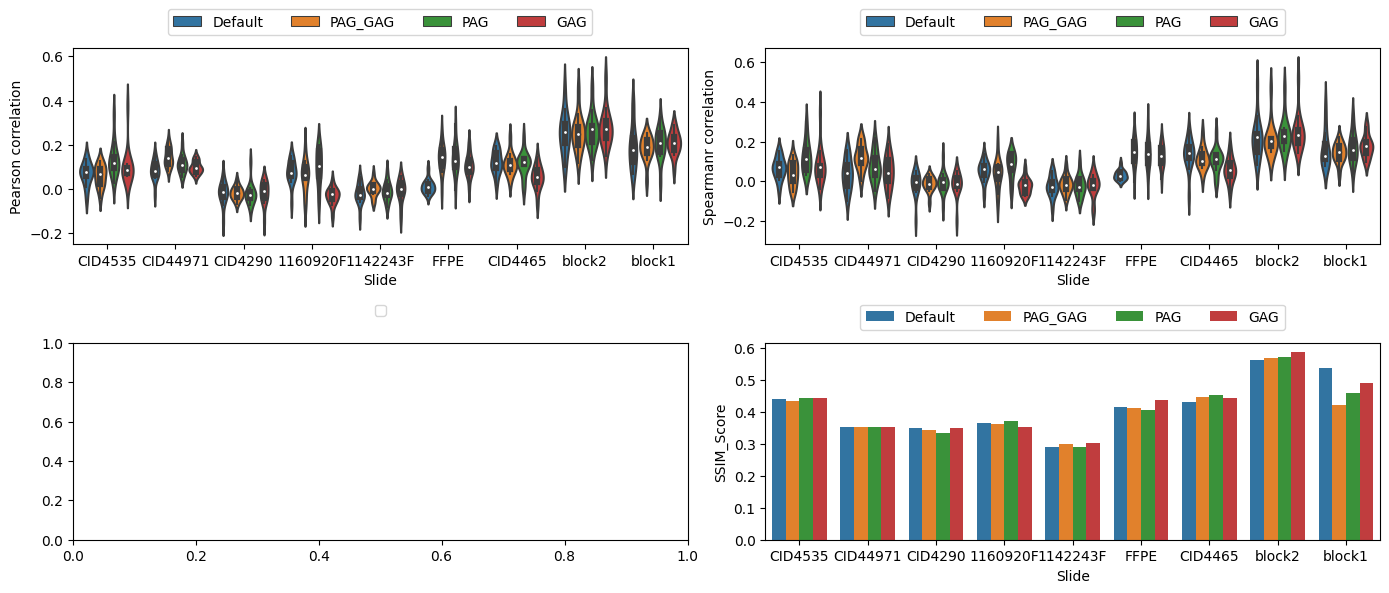

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

gc.collect()
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 6))

# Plot the first figure
sns.violinplot(x='Slide', y='Pearson correlation', hue='Method', data=df1, ax=axs[0][0])
# axs[0].set_title('Pearson Correlation of Predictable Genes Across Slides')

# Plot the second figure
sns.violinplot(x='Slide', y='Spearmanr correlation', hue='Method', data=df1, ax=axs[0][1])

# Plot the third figure
sns.barplot(x='Slide', y='SSIM_Score', hue='Method', data=df1, ax=axs[1][1])
# axs[1].set_title('Spearmanr Correlation of Predictable Genes Across Slides')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Move the legend outside the plot area
for x in axs:
    for ax in x:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.23),
            ncol=7,
        )

# Show the plots
# plt.show()
# plt.savefig("GraphBuild.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


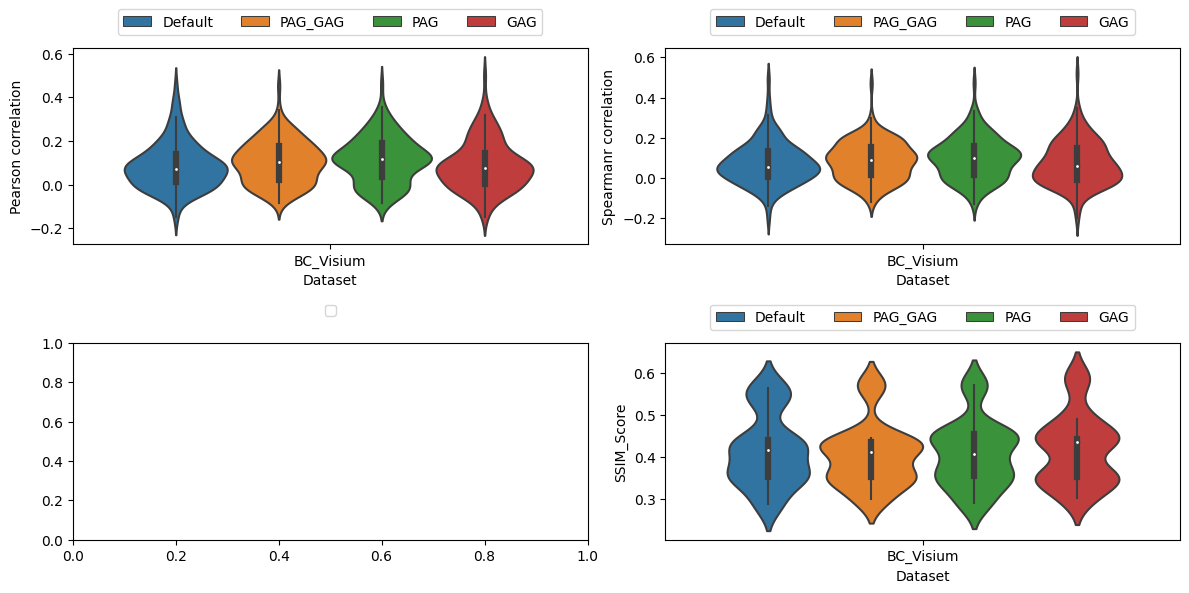

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

gc.collect()
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot the first figure
sns.violinplot(x='Dataset', y='Pearson correlation', hue='Method', data=df1, ax=axs[0][0])
# axs[0].set_title('Pearson Correlation of Predictable Genes Across Slides')

# Plot the second figure
sns.violinplot(x='Dataset', y='Spearmanr correlation', hue='Method', data=df1, ax=axs[0][1])
# axs[1].set_title('Spearmanr Correlation of Predictable Genes Across Slides')

# Plot the third figure
sns.violinplot(x='Dataset', y='SSIM_Score', hue='Method', data=df1, ax=axs[1][1])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Move the legend outside the plot area
for x in axs:
    for ax in x:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.23),
            ncol=7,
        )
# Show the plots
# plt.savefig("GraphBuild_Overview.png")
plt.show()
